# Read and Preprocess data

## import and functions

In [ ]:
!pip install -e ../TrackSelectorDNN/ TrackSelectorDNN 

In [1]:
import uproot
import awkward as ak
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from TrackSelectorDNN.data_manager.dataset import TrackDatasetFromFile

In [2]:
def normalize_features(x, eps=1e-8):
    mean = np.mean(x, axis=(0, 1), keepdims=True)
    std = np.std(x, axis=(0, 1), keepdims=True)
    x_norm = (x - mean) / (std + eps)
    return x_norm, mean, std

def normalize_2d(x, eps=1e-8):
    mean = np.nanmean(x, axis=0, keepdims=True)
    std = np.nanstd(x, axis=0, keepdims=True)
    return (x - mean) / (std + eps), mean, std
    
def summarize_features(X, recoPixelTrackFeatures_names):
    summary = []
    for i, name in enumerate(recoPixelTrackFeatures_names):
        x = X[:, i]
        x_clean = x[~np.isnan(x)]
        min_val = np.min(x_clean)
        max_val = np.max(x_clean)
        mean_val = np.mean(x_clean)
        std_val = np.std(x_clean)
        zero_frac = np.sum(np.isclose(x_clean, 0)) / len(x_clean)
        nan_frac = np.sum(np.isnan(x)) / len(x)
        s = skew(x_clean)
        summary.append({
            "feature": name,
            "min": min_val,
            "max": max_val,
            "mean": mean_val,
            "std": std_val,
            "zeros(%)": 100*zero_frac,
            "NaNs(%)": 100*nan_frac,
            "skew": s
        })
    return summary

def print_summary_table(summary, sort_by="skew", top=10):
    import pandas as pd
    df = pd.DataFrame(summary)
    df_sorted = df.sort_values(by=sort_by, key=lambda x: np.abs(x), ascending=False)
    print(df_sorted.head(top).to_string(index=False))
    return df_sorted

def flag_outliers(summary, std_threshold=100, skew_threshold=5, zero_frac_threshold=80):
    issues = []
    for row in summary:
        if np.isnan(row["std"]) or row["std"] == 0:
            issues.append((row["feature"], "Constant or NaN std"))
        if abs(row["skew"]) > skew_threshold:
            issues.append((row["feature"], f"Highly skewed ({row['skew']:.2f})"))
        if row["zeros(%)"] > zero_frac_threshold:
            issues.append((row["feature"], f"Mostly zeros ({row['zeros(%)']:.1f}%)"))
        if abs(row["max"] - row["min"]) > std_threshold * row["std"]:
            issues.append((row["feature"], "Extreme outlier range"))
    print("\n Potentially problematic features:")
    for f, msg in issues:
        print(f" - {f:30s}: {msg}")
    return issues

def clip_outliers(x, low=0.001, high=0.999):
    lo, hi = np.percentile(x, [100*low, 100*high])
    return np.clip(x, lo, hi), lo, hi

def plot_feature_distributions(
    X_ref,
    feature_names,
    y=None,
    X_cmp=None,
    labels=("Reference", "Comparison"),
    n_cols=4,
    bins=50,
    figsize=(16, 12),
    density=True,
    alpha_ref=0.6,
    alpha_cmp=0.4,
):
    """
    Plot feature distributions for one or two datasets.

    Parameters
    ----------
    X_ref : np.ndarray
        Reference dataset of shape (n_samples, n_features).
    feature_names : list of str
        Names of the features to plot.
    y : np.ndarray, optional
        Binary labels (True/False or 1/0). If given, separate histograms by class.
    X_cmp : np.ndarray, optional
        Comparison dataset (same shape as X_ref) to overlay.
    labels : tuple(str, str)
        Labels for the legend corresponding to (X_ref, X_cmp).
    n_cols : int
        Number of subplot columns.
    bins : int
        Number of histogram bins.
    figsize : tuple
        Overall figure size.
    density : bool
        Whether to normalize histograms to density.
    alpha_ref : float
        Transparency for reference histograms.
    alpha_cmp : float
        Transparency for comparison histograms.
    """

    n_features = X_ref.shape[1]
    n_rows = int(np.ceil(n_features / n_cols))
    plt.figure(figsize=figsize)

    for i, name in enumerate(feature_names):
        plt.subplot(n_rows, n_cols, i + 1)

        # Determine plotting mode
        if y is not None:
            mask_true = (y == 1)
            mask_fake = (y == 0)
            plt.hist(
                X_ref[mask_true, i], bins=bins, alpha=alpha_ref,
                label=f"{labels[0]} True", density=density
            )
            plt.hist(
                X_ref[mask_fake, i], bins=bins, alpha=alpha_ref,
                label=f"{labels[0]} Fake", density=density
            )
            if X_cmp is not None:
                plt.hist(
                    X_cmp[mask_true, i], bins=bins, alpha=alpha_cmp,
                    label=f"{labels[1]} True", density=density, linestyle="dashed"
                )
                plt.hist(
                    X_cmp[mask_fake, i], bins=bins, alpha=alpha_cmp,
                    label=f"{labels[1]} Fake", density=density, linestyle="dashed"
                )
        else:
            plt.hist(X_ref[:, i], bins=bins, alpha=alpha_ref, label=labels[0], density=density)
            if X_cmp is not None:
                plt.hist(X_cmp[:, i], bins=bins, alpha=alpha_cmp, label=labels[1], density=density)

        plt.title(name, fontsize=8)
        plt.tick_params(axis="x", labelsize=7)
        plt.tick_params(axis="y", labelsize=7)

    plt.tight_layout()
    plt.legend(fontsize=7)
    plt.show()

def plot_single_feature(
    X_ref,
    feature_index,
    feature_name=None,
    y=None,
    X_cmp=None,
    labels=("Reference", "Comparison"),
    bins=60,
    figsize=(8, 6),   # slightly larger default figure
    density=True,
    alpha_ref=0.6,
    alpha_cmp=0.4,
    title=None,
    xlabel=None,
    ylabel=None,
):
    """
    Plot the distribution of a single feature from one or two datasets.
    """

    plt.figure(figsize=figsize)

    # Reference only
    if y is None:
        plt.hist(
            X_ref[:, feature_index], bins=bins, density=density,
            alpha=alpha_ref, label=labels[0], color="C0"
        )
        if X_cmp is not None:
            plt.hist(
                X_cmp[:, feature_index], bins=bins, density=density,
                alpha=alpha_cmp, label=labels[1], color="C1"
            )

    # Split by True / Fake
    else:
        mask_true = (y == 1)
        mask_fake = (y == 0)

        plt.hist(
            X_ref[mask_true, feature_index], bins=bins, density=density,
            alpha=alpha_ref, label=f"{labels[0]}: True", color="#022773"
        )
        plt.hist(
            X_ref[mask_fake, feature_index], bins=bins, density=density,
            alpha=alpha_ref, label=f"{labels[0]}: Fake", color="#FF0000"
        )

        if X_cmp is not None:
            plt.hist(
                X_cmp[mask_true, feature_index], bins=bins, density=density,
                alpha=alpha_cmp, label=f"{labels[1]}: True", linestyle="--", color="C2"
            )
            plt.hist(
                X_cmp[mask_fake, feature_index], bins=bins, density=density,
                alpha=alpha_cmp, label=f"{labels[1]}: Fake", linestyle="--", color="C3"
            )

    # --- Titles & Labels ---
    if title is None:
        title = f"Distribution of {feature_name}"
    if xlabel is None:
        xlabel = feature_name
    if ylabel is None:
        ylabel = "Density" if density else "Counts"

    # Larger fonts
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)

    # Larger tick labels
    plt.tick_params(axis='both', labelsize=14)

    plt.grid(alpha=0.25)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

In [161]:
#INPUT_PATH = "ext.root"
INPUT_PATH  = "/shared/data/100_tracks_no-skip-connections_dataset.root"
OUTPUT_PATH = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_train-val_dataset_skip-connections.pt"
OUTPUT_PATH_TRAIN = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_train_dataset_skip-connections.pt"
OUTPUT_PATH_VAL  = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_val_dataset_skip-connections.pt"
MAX_HITS = 16

LOW_PERCENTILE  = 0.001
HIGH_PERCENTILE = 0.999
EPSILON = 1.e-8

## Read data from file

In [162]:
# Open the ROOT file
file = uproot.open(INPUT_PATH)
print(file.keys())

print("")
print("-----------------------------------------------")
print("-----------------------------------------------")
print("")

# Access the Events TTree
events = file["Events"]

# List branches in Events
print("Branches in Events:")

for branch in events.keys():
# Inspect first few entries
    print("   -", branch)

# Read all branches into an awkward array
data = events.arrays(library="ak")

['Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']

-----------------------------------------------
-----------------------------------------------

Branches in Events:
   - run
   - luminosityBlock
   - event
   - bunchCrossing
   - orbitNumber
   - nGenJet
   - GenJet_eta
   - GenJet_mass
   - GenJet_phi
   - GenJet_pt
   - nGenPart
   - GenPart_genPartIdxMother
   - GenPart_statusFlags
   - GenPart_pdgId
   - GenPart_status
   - GenPart_eta
   - GenPart_mass
   - GenPart_phi
   - GenPart_pt
   - nhltPixelTrackRecHits
   - hltPixelTrackRecHits_globalX
   - hltPixelTrackRecHits_globalY
   - hltPixelTrackRecHits_globalZ
   - hltPixelTrackRecHits_globalErrX
   - hltPixelTrackRecHits_globalErrY
   - hltPixelTrackRecHits_globalErrZ
   - hltPixelTrackRecHits_globalR
   - hltPixelTrackRecHits_globalEta
   - hltPixelTrackRecHits_globalPhi
   - nhltPixelTrack
   - hltPixelTrack_isHighPurity
   - hltPixelTrack_isTight
   - hltPixelTrack_duplicate
   - hltPixelTrack_m

Decide which branches contain either input features or output labels

In [163]:
recHitBranches = [
    "hltPixelTrackRecHits_globalX",
    "hltPixelTrackRecHits_globalY",
    "hltPixelTrackRecHits_globalZ",
    "hltPixelTrackRecHits_globalErrX",
    "hltPixelTrackRecHits_globalErrY",
    "hltPixelTrackRecHits_globalErrZ",
    "hltPixelTrackRecHits_globalR",
    "hltPixelTrackRecHits_globalEta",
    "hltPixelTrackRecHits_globalPhi"
]

recoPixelTrackBranches = [
    "hltPixelTrack_matched",
    "hltPixelTrack_isHighPurity",
    "hltPixelTrack_nPixelHits",
    "hltPixelTrack_nTrkLays",
    "hltPixelTrack_charge",
    "hltPixelTrack_chi2",
    "hltPixelTrack_dXY",
    "hltPixelTrack_dZ",
    "hltPixelTrack_dZError",
    "hltPixelTrack_dsz",
    "hltPixelTrack_dszErr",
    "hltPixelTrack_dxyError",
    "hltPixelTrack_eta",
    "hltPixelTrack_etaErr",
    "hltPixelTrack_lambdaErr",
    "hltPixelTrack_ndof",
    "hltPixelTrack_phi",
    "hltPixelTrack_phiErr",
    "hltPixelTrack_pt",
    "hltPixelTrack_ptErr",
    "hltPixelTrack_qoverp",
    "hltPixelTrack_qoverpErr",
    "hltPixelTrack_vx",
    "hltPixelTrack_vy",
    "hltPixelTrack_vz",
    "hltPixelTrack_dzBS",
    "hltPixelTrack_dxyBS"
]

genPartBranches = [
    
]

Read the branches from the file

In [164]:
# Convert Awkward arrays to (n_tracks, MAX_HITS) arrays and stack
recHitFeaturesList = []
for b in recHitBranches:
    arr = ak.to_numpy(ak.flatten(data[b])).reshape(-1,MAX_HITS)  # (n_tracks, MAX_HITS)
    recHitFeaturesList.append(arr)

recHitFeatures = np.stack(recHitFeaturesList, axis=2)  # (n_tracks, MAX_HITS, n_features)

# Create mask (1 = real hit, 0 = padded)
mask = np.isnan(recHitFeatures[:,:,0])  # (n_tracks, MAX_HITS)

# Replace NaNs with 0.0
recHitFeatures[mask] = 0
isRecHit = ~mask

recoPixelTrackList = []
for b in recoPixelTrackBranches:
    arr = ak.to_numpy(ak.flatten(data[b]))  # (n_tracks,)
    recoPixelTrackList.append(arr)

genPartList = []
for b in genPartBranches:
    arr = ak.to_numpy(data[b])  # (n_tracks,)
    genPartList.append(arr)

recoPixelTrackFeatures = np.stack(recoPixelTrackList[2:], axis=1)  # (n_tracks, n_features)
recoPixelTrackLabels = np.array(recoPixelTrackList[0])
recoPixelTrackIsHighPurity = np.array(recoPixelTrackList[1])
recoPixelTrackFeatures_names = recoPixelTrackBranches[2:]  # skip 'hltPixelTrack_matched and IsHP' (label)
genPart = np.array(genPartList)

chi2_over_ndof = recoPixelTrackFeatures[:,3]/recoPixelTrackFeatures[:,13]
mask_true = (recoPixelTrackLabels==1)
mask_fake = (recoPixelTrackLabels==0)
npixel_hits = recoPixelTrackFeatures[:,0]
mask_hits   = (npixel_hits==2)

(array([19927., 11967., 10823., 10949., 10632., 10408.,  9814.,  9525.,
         8951.,  8647.]),
 array([1.12022797e-03, 1.00097001e+00, 2.00081992e+00, 3.00066972e+00,
        4.00051975e+00, 5.00036955e+00, 6.00021935e+00, 7.00006914e+00,
        7.99991894e+00, 8.99976826e+00, 9.99961853e+00]),
 <BarContainer object of 10 artists>)

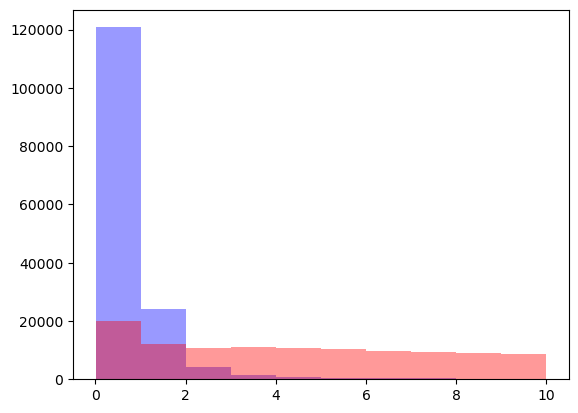

In [165]:
plt.hist(chi2_over_ndof[mask_true], color='blue', alpha=0.4,density=False)
plt.hist(chi2_over_ndof[~mask_true], color='red', alpha=0.4,density=False)

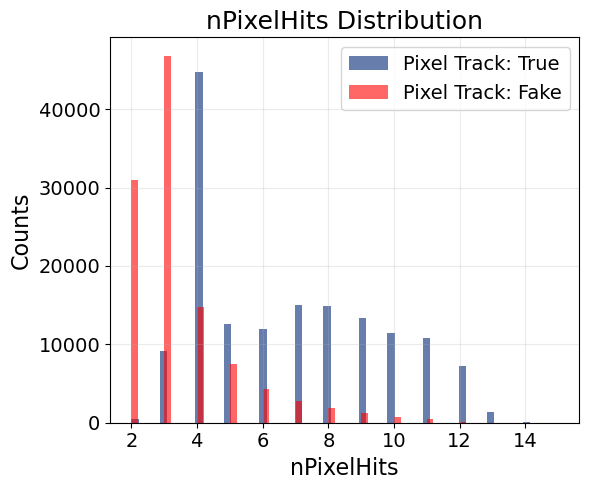

In [166]:
fname = "hltPixelTrack_nPixelHits"
i = recoPixelTrackFeatures_names.index(fname)

plot_single_feature(
    X_ref=recoPixelTrackFeatures,
    feature_index=i,
    feature_name=fname,
    y=recoPixelTrackLabels,
    density=False,
    figsize=(6, 5),
    labels=("Pixel Track", ""),
    title="nPixelHits Distribution",
    xlabel="nPixelHits"
)

In [167]:
mask_chi2_5 = (chi2_over_ndof > 5)
mask_chi2_7 = (chi2_over_ndof > 7)

true_hits  = recoPixelTrackLabels[mask_hits].sum()
true_chi_5 = recoPixelTrackLabels[mask_chi2_5].sum()
true_chi_7 = recoPixelTrackLabels[mask_chi2_7].sum()

fake_hits = recoPixelTrackLabels[mask_hits].shape[0] - true_hits
fake_chi_5 = recoPixelTrackLabels[mask_chi2_5].shape[0] - true_chi_5
fake_chi_7 = recoPixelTrackLabels[mask_chi2_7].shape[0] - true_chi_7

print("True tracks: ", true_hits, true_chi_5, true_chi_7) 
print("Fake tracks: ", fake_hits, fake_chi_5, fake_chi_7) 

True tracks:  488 1634 698
Fake tracks:  30972.0 47347.0 27123.0


In [11]:
print("recHitFeatures: ", recHitFeatures.shape)
print("recoPixelTrackFeatures: ", recoPixelTrackFeatures.shape)
print("isRecHit: ", isRecHit.shape)

recHitFeatures:  (264758, 16, 9)
recoPixelTrackFeatures:  (264758, 25)
isRecHit:  (264758, 16)


In [12]:
N = recoPixelTrackLabels.shape[0]
N_true = recoPixelTrackLabels.sum()
N_fake = N - N_true

w_true = N / (2 * N_true)
w_fake = N / (2 * N_fake)

print(w_true, w_fake)

0.8645723802370767 1.185734887095474


In [13]:
recoPixelTrackLabels.sum()/recoPixelTrackLabels.shape[0]

0.5783205795481157

## Preprocessing

### RecoPixelTracks

Inspect the properties of recoPixelTrack features to look for potential problems

In [102]:
# Compute feature statistics
summary = summarize_features(recoPixelTrackFeatures, recoPixelTrackFeatures_names)
summary_df = print_summary_table(summary, sort_by="skew", top=15)

                 feature       min          max      mean          std  zeros(%)  NaNs(%)       skew
  hltPixelTrack_dxyError  0.000558 8.785193e+02  0.036858     1.865511  0.000000      0.0 412.105705
    hltPixelTrack_phiErr  0.000138 2.701934e+02  0.010441     0.585128  0.000000      0.0 394.359807
     hltPixelTrack_ptErr  0.010045 4.390888e+06 39.349792 10168.588867  0.000000      0.0 364.626939
        hltPixelTrack_pt  0.714977 1.410433e+04  2.483947    53.902157  0.000000      0.0 174.639800
   hltPixelTrack_dZError  0.001636 9.999201e-01  0.061338     0.098187  0.000000      0.0   2.550335
      hltPixelTrack_chi2  0.005066 2.032610e+02 11.790421    11.616574  0.000000      0.0   2.470685
    hltPixelTrack_dszErr  0.000716 6.550348e-02  0.007878     0.004711  0.000000      0.0   2.032305
 hltPixelTrack_qoverpErr  0.000473 3.790320e-02  0.008718     0.004259  0.000000      0.0   0.950126
    hltPixelTrack_etaErr  0.000170 7.456919e-03  0.001783     0.000831  0.000000      0.0  

In [103]:
issues = flag_outliers(summary)


 Potentially problematic features:
 - hltPixelTrack_dxyError        : Highly skewed (412.11)
 - hltPixelTrack_dxyError        : Extreme outlier range
 - hltPixelTrack_phiErr          : Highly skewed (394.36)
 - hltPixelTrack_phiErr          : Extreme outlier range
 - hltPixelTrack_pt              : Highly skewed (174.64)
 - hltPixelTrack_pt              : Extreme outlier range
 - hltPixelTrack_ptErr           : Highly skewed (364.63)
 - hltPixelTrack_ptErr           : Extreme outlier range


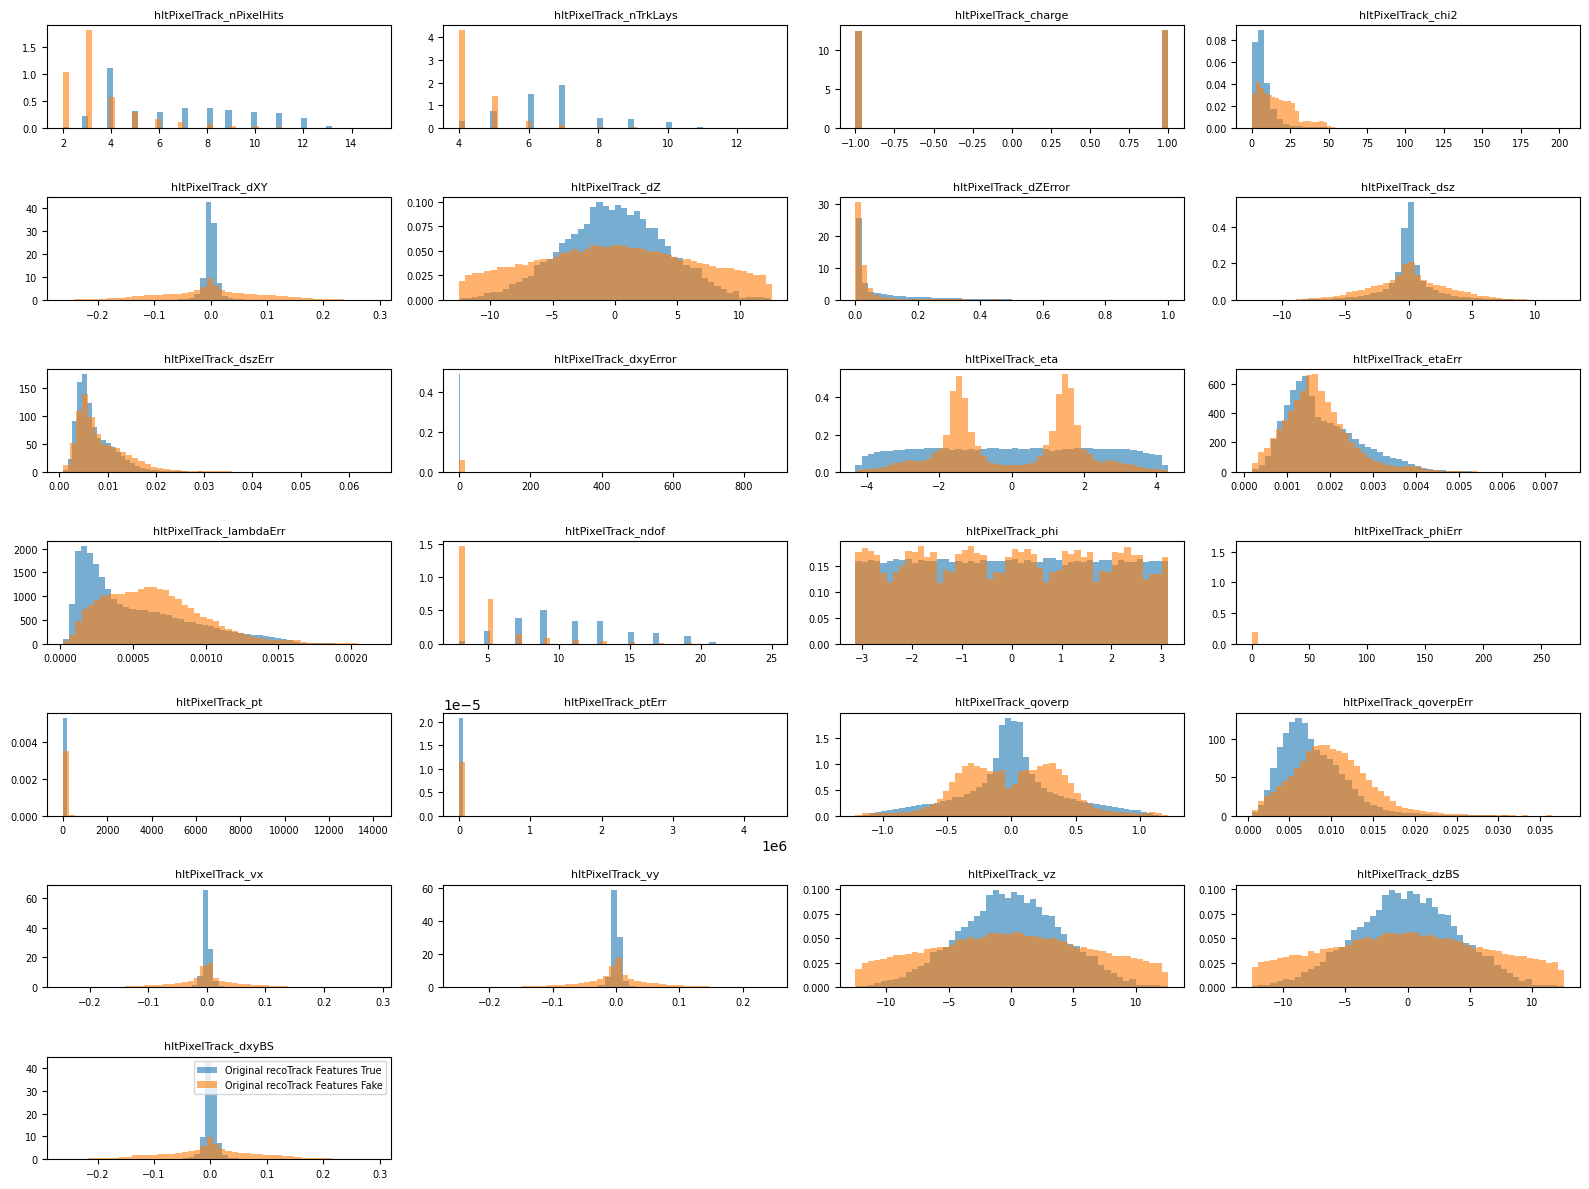

In [104]:
plot_feature_distributions(
    X_ref=recoPixelTrackFeatures,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Original recoTrack Features",)
)

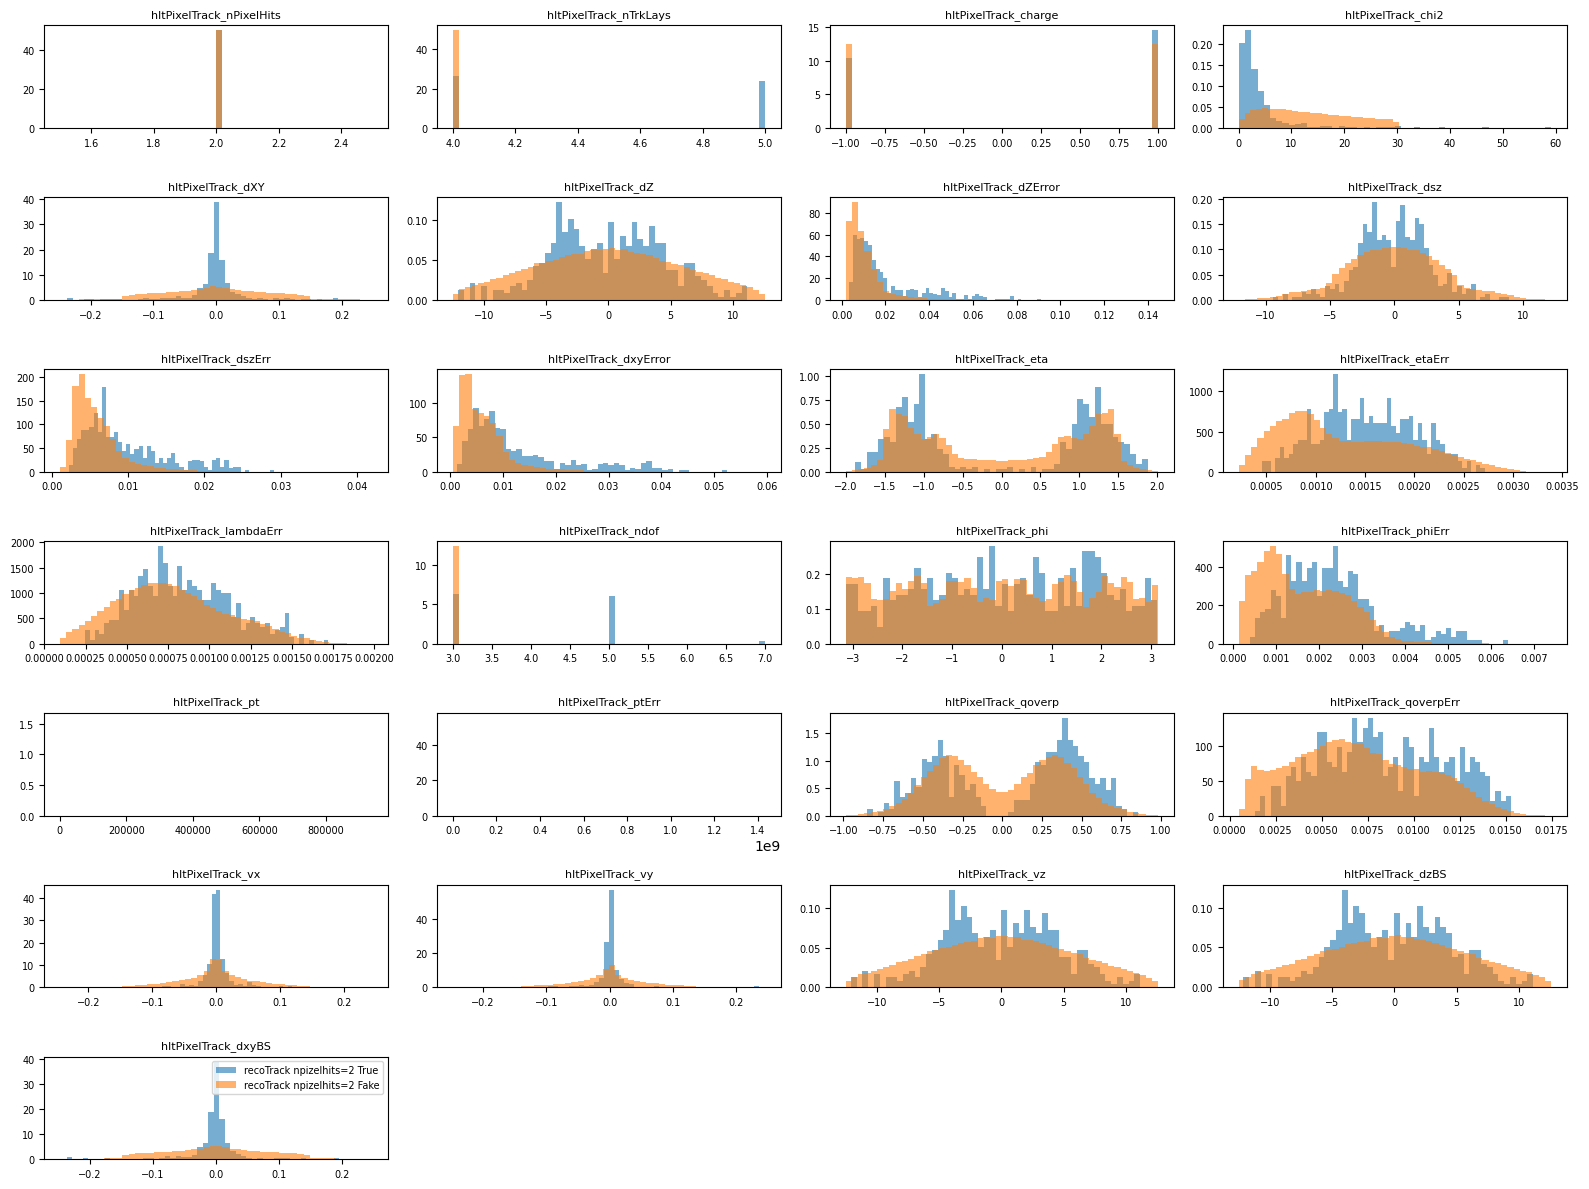

In [50]:
plot_feature_distributions(
    X_ref=recoPixelTrackFeatures[mask_hits,:],
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels[mask_hits],
    labels=("recoTrack npizelhits=2",)
)

Apply clipping and log transformation where needed 

In [51]:
do_log_track = []

In [52]:
# Variables to log-transform and clip
log_vars = ["hltPixelTrack_pt", "hltPixelTrack_ptErr", 
            "hltPixelTrack_dxyError", "hltPixelTrack_phiErr", 
            "hltPixelTrack_chi2", "hltPixelTrack_dszErr",
            "hltPixelTrack_dZError", "hltPixelTrack_qoverpErr", "hltPixelTrack_lambdaErr", "hltPixelTrack_etaErr"]

recoPixelTrackFeatures_proc = recoPixelTrackFeatures.copy()
for i, name in enumerate(recoPixelTrackFeatures_names):
    do_log_track.append(name in log_vars)
    if name in log_vars:
        x = recoPixelTrackFeatures_proc[:, i]
        x = np.log10(EPSILON+x)
        #x = clip_outliers(x, low=LOW_PERCENTILE, high=HIGH_PERCENTILE)
        recoPixelTrackFeatures_proc[:, i] = x


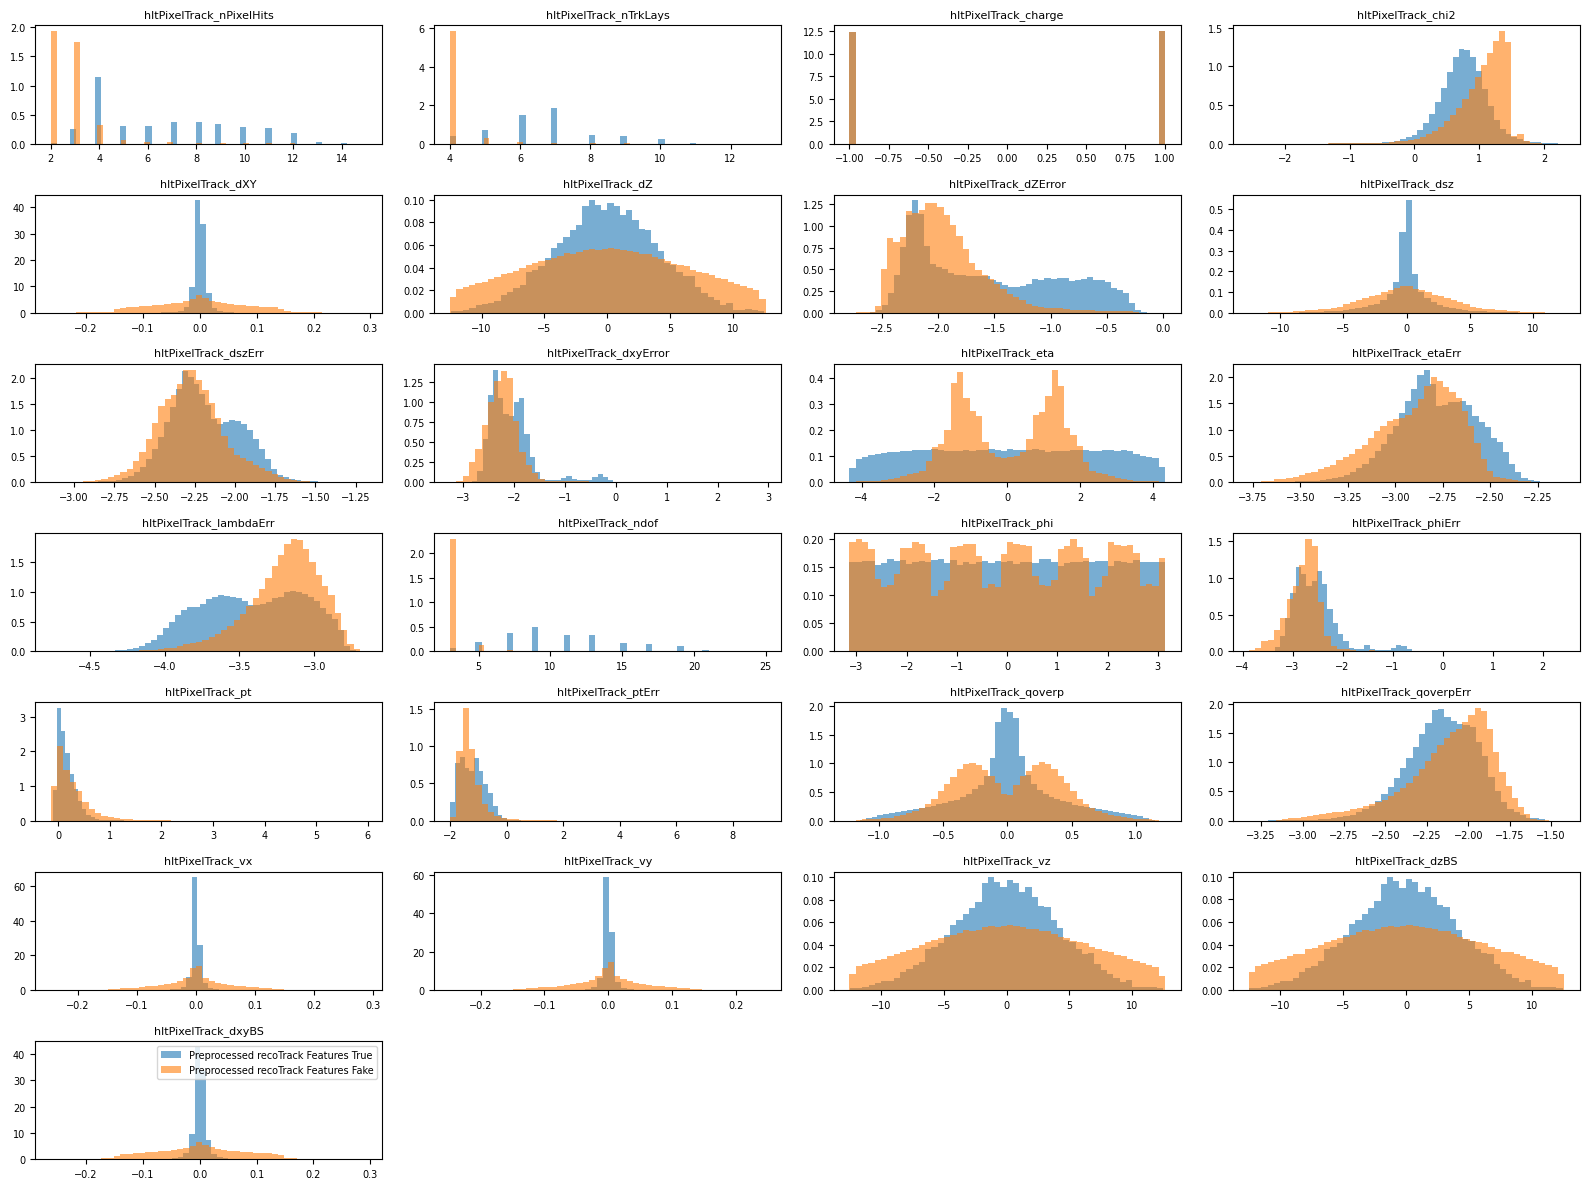

In [53]:
plot_feature_distributions(
    X_ref=recoPixelTrackFeatures_proc,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Preprocessed recoTrack Features",)
)

In [54]:
clip_min_track = []
clip_max_track = []

In [55]:
# Variables to just clip
clip_vars = [
    "hltPixelTrack_pt", "hltPixelTrack_ptErr", 
    "hltPixelTrack_dxyError", "hltPixelTrack_phiErr", 
    "hltPixelTrack_chi2", "hltPixelTrack_dszErr",
    "hltPixelTrack_dZError", "hltPixelTrack_qoverpErr", "hltPixelTrack_lambdaErr", "hltPixelTrack_etaErr",
    "hltPixelTrack_dXY", "hltPixelTrack_dsz", 
    "hltPixelTrack_vx", "hltPixelTrack_vy"]

for i, name in enumerate(recoPixelTrackFeatures_names):
    if name in clip_vars:
        x = recoPixelTrackFeatures_proc[:, i]
        x, lo, hi = clip_outliers(x, low=LOW_PERCENTILE, high=HIGH_PERCENTILE)
        recoPixelTrackFeatures_proc[:, i] = x
        clip_min_track.append(lo)
        clip_max_track.append(hi)
    else:
        clip_min_track.append(np.nan)
        clip_max_track.append(np.nan)

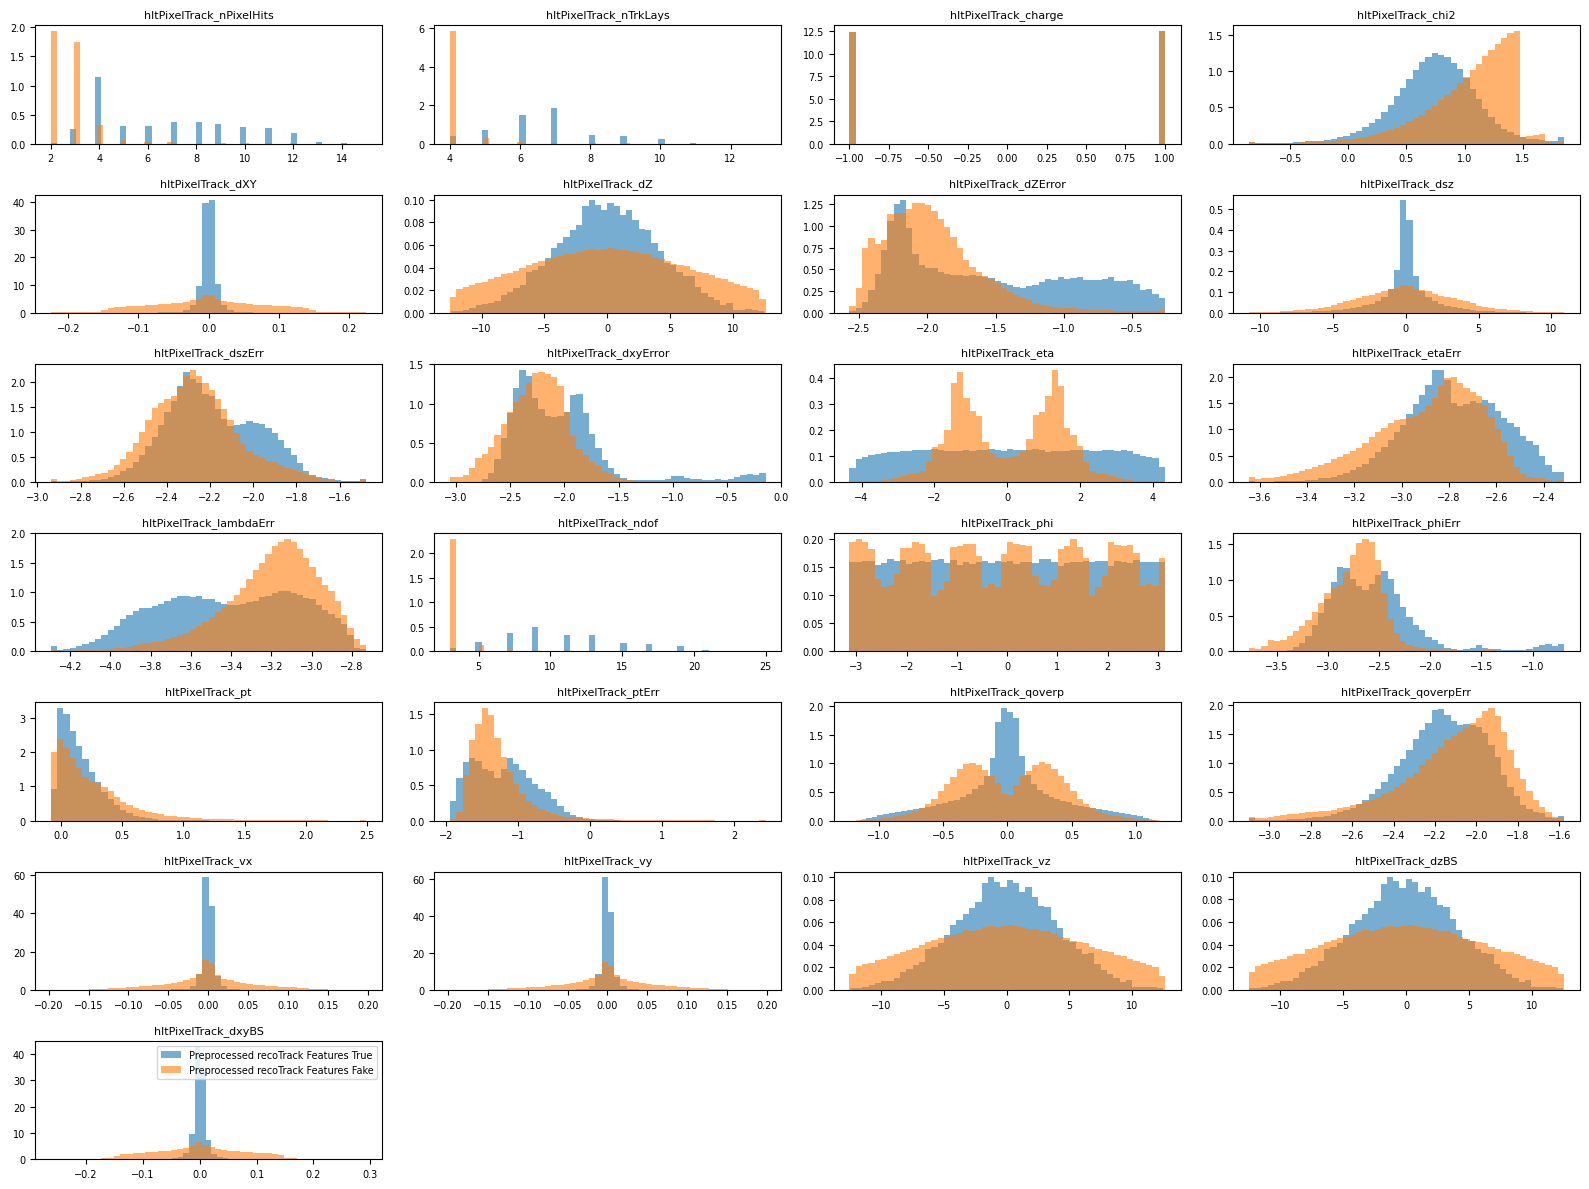

In [56]:
plot_feature_distributions(
    X_ref=recoPixelTrackFeatures_proc,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Preprocessed recoTrack Features",)
)

Apply normalization

In [57]:
recoPixelTrackFeaturesNorm, recoPixelTrack_mean, recoPixelTrack_std = normalize_2d(recoPixelTrackFeatures_proc)

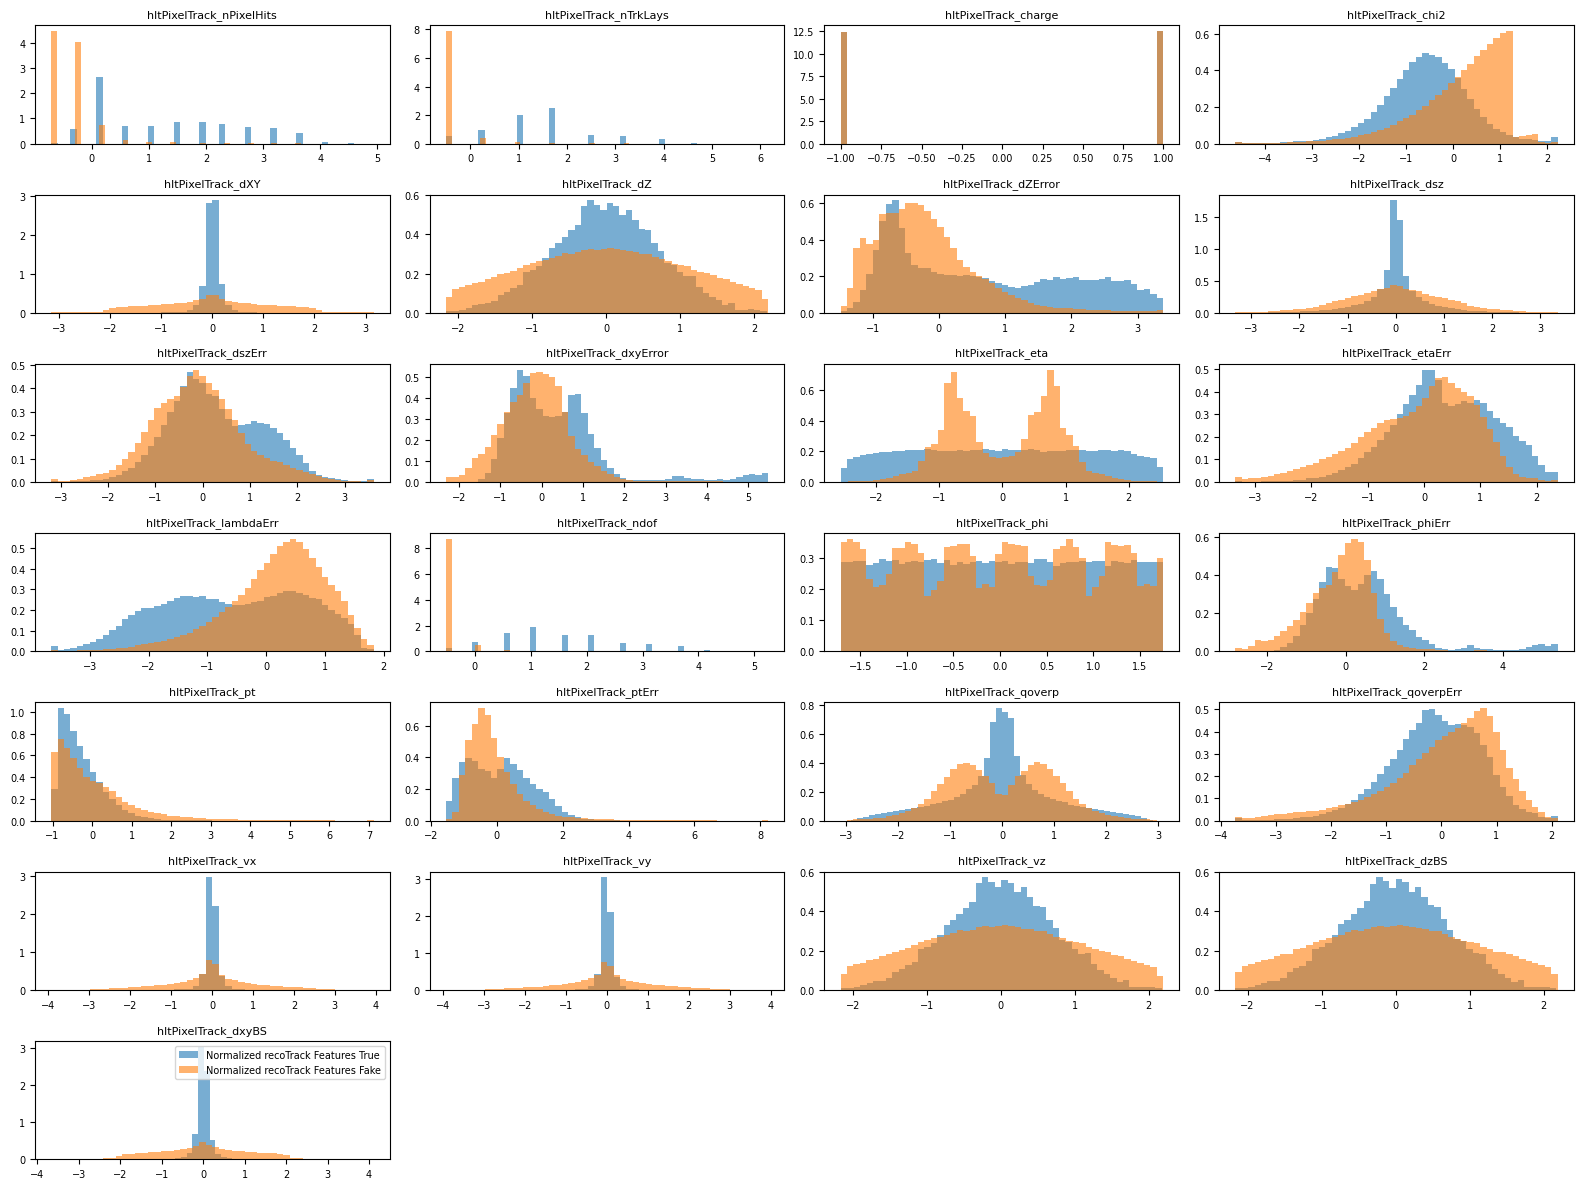

In [58]:
plot_feature_distributions(
    X_ref=recoPixelTrackFeaturesNorm,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Normalized recoTrack Features",)
)

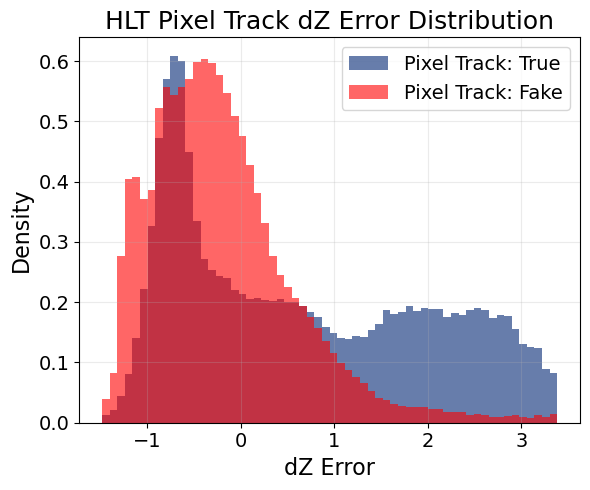

In [59]:
fname = "hltPixelTrack_dZError"
i = recoPixelTrackFeatures_names.index(fname)

plot_single_feature(
    X_ref=recoPixelTrackFeaturesNorm,
    feature_index=i,
    feature_name=fname,
    y=recoPixelTrackLabels,
    figsize=(6, 5),
     labels=("Pixel Track", ""),
    title="HLT Pixel Track dZ Error Distribution",
    xlabel="dZ Error"
)

In [60]:
summary_norm = summarize_features(recoPixelTrackFeaturesNorm, recoPixelTrackFeatures_names)
summary_norm_df = print_summary_table(summary_norm, sort_by="skew", top=15)

                 feature       min      max          mean      std  zeros(%)  NaNs(%)      skew
     hltPixelTrack_ptErr -1.545767 8.240782  6.279343e-05 1.000136  0.000000      0.0  2.558436
        hltPixelTrack_pt -1.037408 7.116273  6.366129e-06 1.000119  0.000000      0.0  2.431529
  hltPixelTrack_nTrkLays -0.507254 6.163778  1.090239e-07 1.001058  0.000000      0.0  2.106190
hltPixelTrack_nPixelHits -0.711604 4.936378  6.310129e-08 0.998145  0.000000      0.0  2.022867
      hltPixelTrack_ndof -0.518378 5.250238  1.776485e-08 0.998556  0.000000      0.0  2.019704
  hltPixelTrack_dxyError -2.317647 5.481570 -1.451044e-04 1.000169  0.000000      0.0  1.630208
   hltPixelTrack_dZError -1.484944 3.382557 -9.955909e-05 1.000149  0.000000      0.0  1.252644
    hltPixelTrack_phiErr -2.802015 5.387320  1.400126e-04 1.000175  0.000000      0.0  1.086600
      hltPixelTrack_chi2 -4.631482 2.222344  1.185957e-04 1.000109  0.000000      0.0 -0.921590
 hltPixelTrack_qoverpErr -3.746379 2.112

In [61]:
issues = flag_outliers(summary_norm)


 Potentially problematic features:


### RecHits

In [150]:
def masked_flatten(feat3d, mask):
    """
    feat3d: (n_tracks, n_hits, n_features)
    mask:   (n_tracks, n_hits) boolean True=real, False=padded
    returns flat array of real values for each feature: list of arrays length n_features
    """
    n_features = feat3d.shape[2]
    flat_per_feature = []
    for f in range(n_features):
        vals = feat3d[:,:,f][mask]      # selects only real hits
        flat_per_feature.append(vals)
    return flat_per_feature


def summarize_recHits(feat3d, mask, feature_names):
    """
    Summarize statistics for recHit features.
    Returns a list of dicts (one dict per summary record).
    """
    n_tracks, n_hits, n_feats = feat3d.shape
    summary = []

    # global per-feature
    flat = masked_flatten(feat3d, mask)
    for f, arr in enumerate(flat):
        if arr.size == 0:
            continue
        summary.append({
            "feature": feature_names[f],
            "n": arr.size,
            "min": float(np.min(arr)),
            "max": float(np.max(arr)),
            "mean": float(np.mean(arr)),
            "std": float(np.std(arr)),
            "zeros(%)": 100.0 * np.sum(np.isclose(arr, 0.0)) / arr.size,
            "skew": float(skew(arr))
        })
    return summary


# --- Mask-aware transforms --------------------------------------------------

def compute_percentile_bounds(feat3d, mask, feature_idx, low=0.001, high=0.999):
    """
    Return (lo, hi).
    """

    vals = feat3d[:,:,feature_idx][mask]
    lo, hi = np.nanpercentile(vals, [100*low, 100*high])
    return (lo, hi)


def clip_outliers_3d(feat3d, mask, feature_idx, low=0.001, high=0.999):
    """Return a copy with clipped values (only real-hit entries considered)."""
    out = feat3d.copy()
    lo, hi = compute_percentile_bounds(feat3d, mask, feature_idx, low, high)
    sel = mask
    vals = out[:,:,feature_idx]
    vals[sel] = np.clip(vals[sel], lo, hi)
    out[:,:,feature_idx] = vals
    return out, lo, hi


def masked_log_transform(feat3d, mask, feature_idx, eps=1e-8, method='log1p'):
    """
    Apply transform only to real hits (mask==True). Supports:
      - 'log1p'  : log1p(x)
      - 'log_eps': log(x + eps)
      - 'neglog' : -log(x + eps)
      - 'reciprocal_log' : log1p(1 / (x + eps))
    Returns copy.
    """
    out = feat3d.copy()
    sel = mask
    vals = out[:,:,feature_idx]
    if method == 'log1p':
        vals[sel] = np.log1p(vals[sel])
    elif method == 'log_eps':
        vals[sel] = np.log10(vals[sel] + eps)
    elif method == 'signed_log_eps':
        vals[sel] = np.sign(vals[sel])*np.log10(np.abs(vals[sel]) + eps)
    else:
        raise ValueError("unknown method")
    out[:,:,feature_idx] = vals
    return out


# --- Mask-aware normalization ------------------------------------------------

def normalize_features_masked(feat3d, mask, eps=1e-8):
    """
    Returns feat3d_norm, mean, std
    mean/std have shape (1,1,n_features)
    Normalisation applied only to mask True values; padded slots remain (set to 0 after normalization).
    """
    out = feat3d.copy().astype(float)
    n_tracks, n_hits, n_feats = out.shape
    mean = np.zeros((1,1,n_feats), dtype=float)
    std  = np.ones((1,1,n_feats), dtype=float)
    for f in range(n_feats):
        vals = out[:,:,f][mask]
        if vals.size == 0:
            mean[0,0,f] = 0.0
            std[0,0,f] = 1.0
        else:
            m = np.nanmean(vals)
            s = np.nanstd(vals)
            mean[0,0,f] = m
            std[0,0,f] = s
            tmp = out[:,:,f]
            sel = mask
            tmp[sel] = (tmp[sel] - m) / (s + eps)
            out[:,:,f] = tmp
    out[~mask] = 0.0
    return out, mean, std

def plot_cms_tracker_background(true_hits, isRecHit_true, r_idx, z_idx, 
                                gridsize=500, cmap="inferno", 
                                save_path=None):
    """
    Plot a hexbin of CMS tracker hits in r-z plane.

    Parameters
    ----------
    true_hits : array
        Shape (n_tracks, max_hits, n_features)
    isRecHit_true : array
        Boolean mask for valid hits, same shape as first two dims of true_hits
    r_idx: int
        Index of the r hit coordinate
    z_idx: int
        Index of the z hit coordinate
    gridsize : int
        Hexbin resolution
    cmap : str
        Colormap
    save_path : str or None
        If given, save the figure to this path
    """
    # Flatten hits and apply mask
    r_hits = true_hits[..., r_idx][isRecHit_true]
    z_hits = true_hits[..., z_idx][isRecHit_true]

    # Remove zeros (padding)
    valid = r_hits > 1e-3
    r_hits = r_hits[valid]
    z_hits = z_hits[valid]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    hb = ax.hexbin(
        z_hits,
        r_hits,
        gridsize=gridsize,
        bins="log",
        cmap=cmap,
        mincnt=1
    )

    cbar = fig.colorbar(hb, ax=ax)
    cbar.set_label("log10(N hits)")

    ax.set_xlabel("z [cm]")
    ax.set_ylabel("r [cm]")
    ax.set_title("CMS tracker hits")
    ax.grid(alpha=0.2)
    ax.set_aspect("equal")

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close()

In [151]:
summary_recHits = summarize_recHits(recHitFeatures, isRecHit, recHitBranches)
summary_recHits_df = print_summary_table(summary_recHits, sort_by="skew", top=15)

                        feature       n           min        max      mean       std  zeros(%)      skew
hltPixelTrackRecHits_globalErrY 3393239  8.275480e-36   0.001625  0.000139  0.000343  1.770756  2.609187
hltPixelTrackRecHits_globalErrX 3393239  6.770847e-36   0.001572  0.000139  0.000344  1.290949  2.606415
hltPixelTrackRecHits_globalErrZ 3393239  0.000000e+00   0.001793  0.000218  0.000461 36.504679  2.494299
   hltPixelTrackRecHits_globalR 3393239  2.750000e+00  55.250000 14.244828 11.267316  0.000000  1.121030
 hltPixelTrackRecHits_globalEta 3393239 -4.312500e+00   4.312500  0.013057  1.923824  0.002711 -0.010494
   hltPixelTrackRecHits_globalZ 3393239 -2.660000e+02 266.000000  0.383186 68.025360  0.002711  0.004986
   hltPixelTrackRecHits_globalX 3393239 -5.500000e+01  55.000000 -0.023493 12.864643  0.000000 -0.004601
   hltPixelTrackRecHits_globalY 3393239 -5.525000e+01  55.250000  0.005078 12.820359  0.000000 -0.001494
 hltPixelTrackRecHits_globalPhi 3393239 -3.140625e+00  

In [58]:
issues_recHits = flag_outliers(summary_recHits)


 Potentially problematic features:


In [172]:
# -------------------------------
# Parameters
max_tracks = 10000
r_idx = 6
z_idx = 2
n_tracks_to_plot = 50

# -------------------------------
# Shuffle tracks
N = recHitFeatures.shape[0]
rng = np.random.default_rng(seed=45)  
perm = rng.permutation(N)

recHitFeatures_shuf = recHitFeatures[perm]
isRecHit_shuf       = isRecHit[perm]
recoPixelTrackLabels_shuf = recoPixelTrackLabels[perm]

# Skim max_tracks
recoPixelTrackLabels_skim = recoPixelTrackLabels_shuf[:max_tracks, ...].astype(bool)
recHitFeatures_skim      = recHitFeatures_shuf[:max_tracks, ...]
isRecHit_skim            = isRecHit_shuf[:max_tracks, ...]

# Select only reco pixel tracks
true_hits = recHitFeatures_skim[recoPixelTrackLabels_skim, ...]
isRecHit_true = isRecHit_skim[recoPixelTrackLabels_skim, ...]

# Extract r and z coordinates
r = true_hits[..., r_idx]
z = true_hits[..., z_idx]

r_hits = r[isRecHit_true]
z_hits = z[isRecHit_true]

# Select fake tracks for plotting
plot_mask = mask_fake & mask_hits
hits_fake =  recHitFeatures[plot_mask, ...]

if hits_fake.shape[0] < n_tracks_to_plot:
    n_tracks_to_plot = hits_fake.shape[0]

track_indices = rng.choice(hits_fake.shape[0], size=n_tracks_to_plot, replace=False)

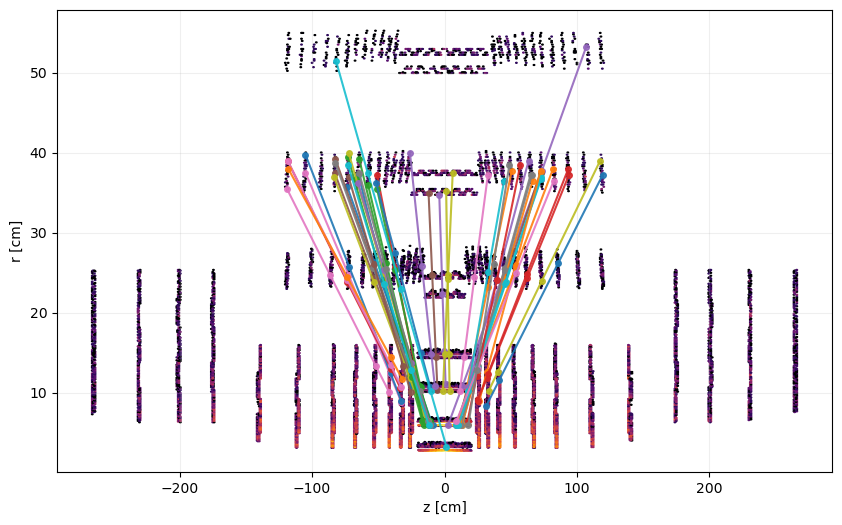

In [173]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot background first
hb = ax.hexbin(z_hits, r_hits, gridsize=500, bins="log", cmap="inferno", mincnt=1)

# Overlay random fake tracks
for i in track_indices:
    track_hits = hits_fake[i]
    z_track = track_hits[..., z_idx]
    r_track = track_hits[..., r_idx]
    mask_padding = ((z_track!=0) & (r_track!=0))
    r_track = r_track[mask_padding]
    z_track = z_track[mask_padding]
    
    ax.plot(z_track, r_track, "-o", lw=1.5, ms=4, alpha=0.9, label="fake track")

ax.set_xlabel("z [cm]")
ax.set_ylabel("r [cm]")
ax.grid(alpha=0.2)
plt.show()

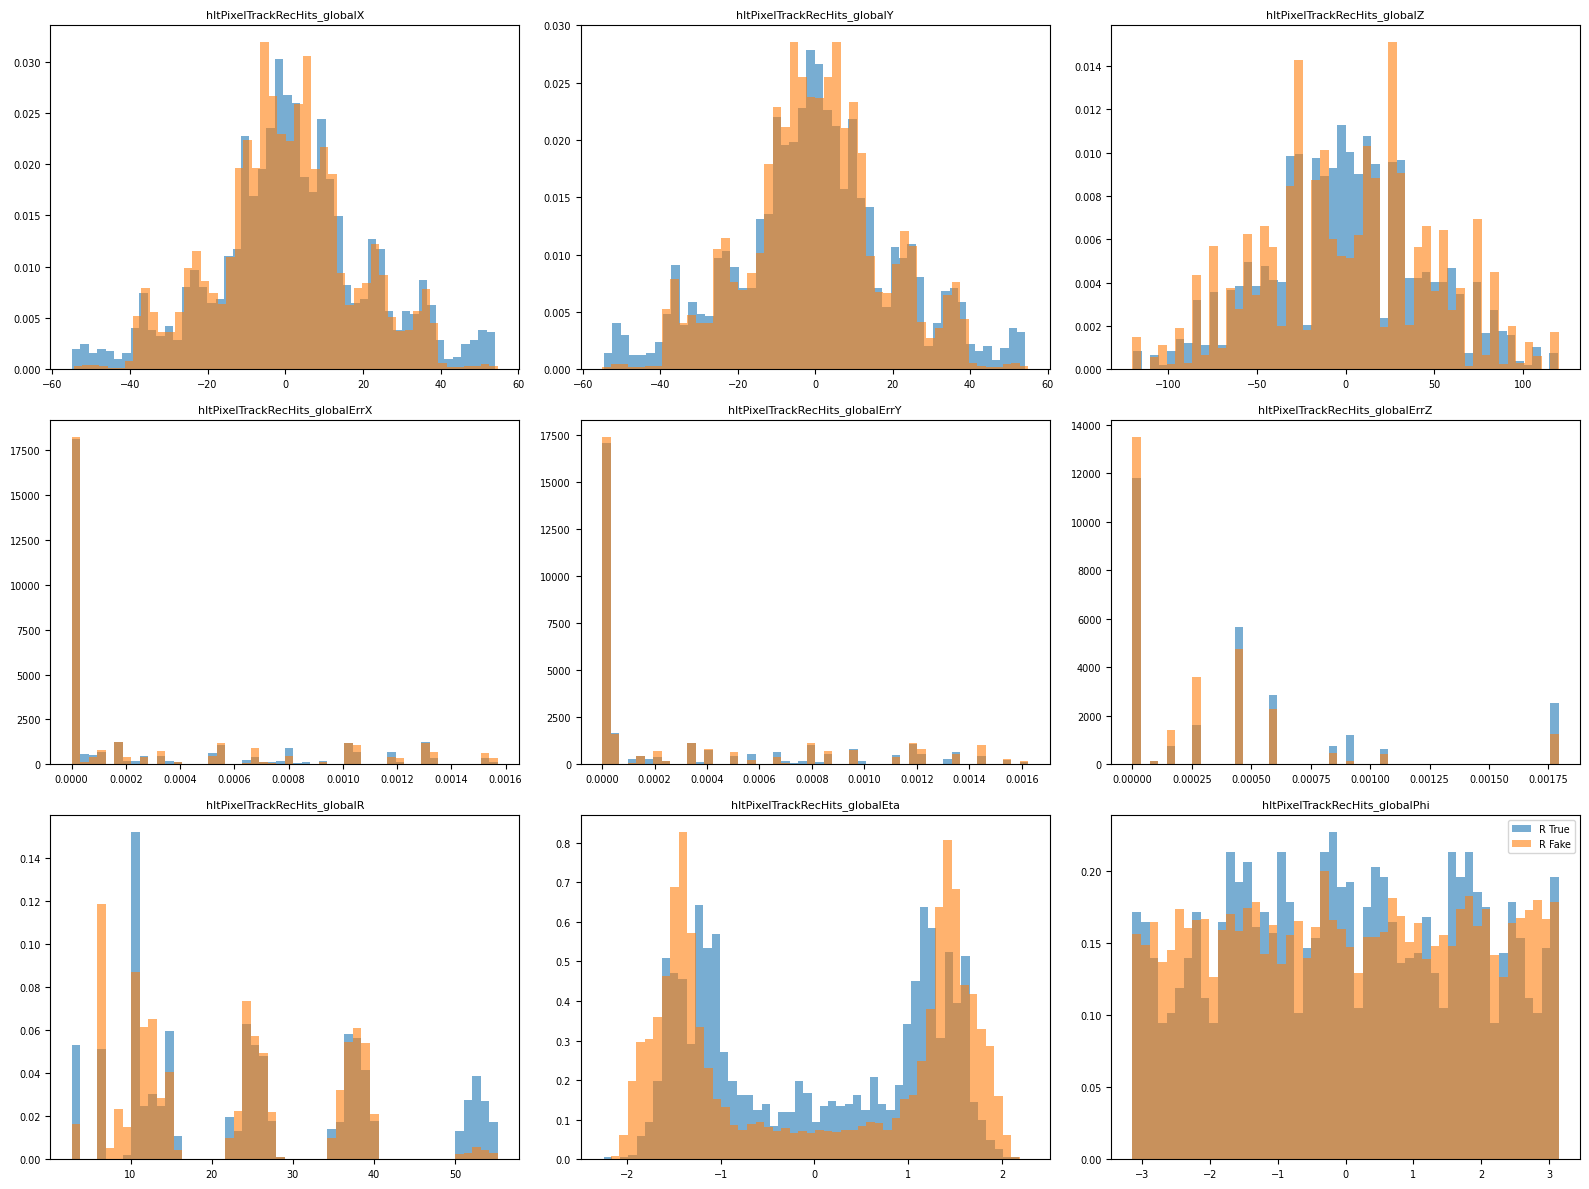

In [67]:
recHitFeatures_flat = np.array(masked_flatten(recHitFeatures[mask_hits,:,:], isRecHit[mask_hits])).T

# Optional: if you want to color by track label (e.g. true/fake track)
y_hits = np.repeat(recoPixelTrackLabels[mask_hits], isRecHit[mask_hits].sum(axis=1))  # only if you want to compare by label

plot_feature_distributions(
    X_ref=recHitFeatures_flat,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [39]:
recHitBranches

['hltPixelTrackRecHits_globalX',
 'hltPixelTrackRecHits_globalY',
 'hltPixelTrackRecHits_globalZ',
 'hltPixelTrackRecHits_globalErrX',
 'hltPixelTrackRecHits_globalErrY',
 'hltPixelTrackRecHits_globalErrZ',
 'hltPixelTrackRecHits_globalR',
 'hltPixelTrackRecHits_globalEta',
 'hltPixelTrackRecHits_globalPhi']

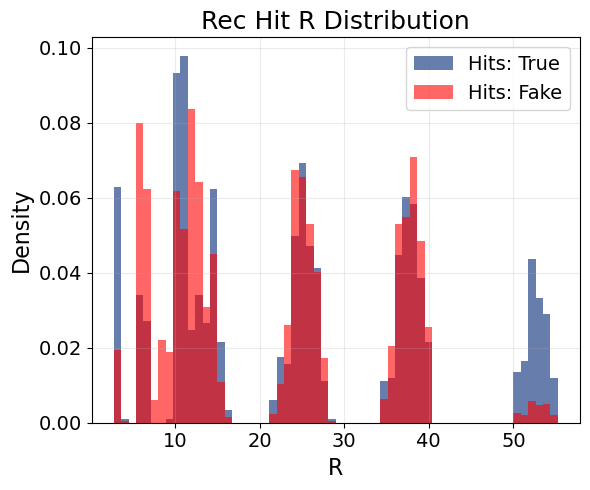

In [156]:
fname = "hltPixelTrackRecHits_globalR"
i = recHitBranches.index(fname)

plot_single_feature(
    X_ref=recHitFeatures_flat,
    feature_index=i,
    feature_name=fname,
    y=y_hits,
    density=True,
    figsize=(6, 5),
     labels=("Hits", ""),
    title="Rec Hit R Distribution",
    xlabel="R"
)

In [35]:
do_log_hit = []

In [36]:
log_recHit_vars = ["hltPixelTrackRecHits_globalR", "hltPixelTrackRecHits_globalErrX", "hltPixelTrackRecHits_globalErrY", "hltPixelTrackRecHits_globalErrZ"]
       
recHitFeatures_proc = recHitFeatures.copy()
for f, name in enumerate(recHitBranches):
    do_log_hit.append(name in log_recHit_vars)
    if name in log_recHit_vars:
        print(f, name)
        recHitFeatures_proc = masked_log_transform(recHitFeatures_proc, isRecHit, f, eps=EPSILON, method='log_eps')
        #recHitFeatures_proc = clip_outliers_3d(recHitFeatures_proc, isRecHit, f, 0.1, 0.99)

3 hltPixelTrackRecHits_globalErrX
4 hltPixelTrackRecHits_globalErrY
5 hltPixelTrackRecHits_globalErrZ
6 hltPixelTrackRecHits_globalR


In [ ]:
recHitFeatures_proc_plot = np.array(masked_flatten(recHitFeatures_proc, isRecHit)).T

plot_feature_distributions(
    X_ref=recHitFeatures_proc_plot,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [ ]:
recHitFeatures_norm, recHit_mean, recHit_std = normalize_features_masked(recHitFeatures_proc, isRecHit, eps=EPSILON)

recHitFeatures_norm_plot = np.array(masked_flatten(recHitFeatures_norm, isRecHit)).T

plot_feature_distributions(
    X_ref=recHitFeatures_norm_plot,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [ ]:
clip_min_hit = [np.nan for i in enumerate(recHitBranches)]
clip_max_hit = [np.nan for i in enumerate(recHitBranches)]

## Data saving

In [ ]:
save_dict = {
    # --- Core datasets ---
    "recHitFeatures": torch.tensor(recHitFeatures_norm, dtype=torch.float32),
    "isRecHit": torch.tensor(isRecHit, dtype=torch.bool),
    "recoPixelTrackFeatures": torch.tensor(recoPixelTrackFeaturesNorm, dtype=torch.float32),
    "labels": torch.tensor(recoPixelTrackLabels, dtype=torch.float32),
    "isHighPurity": torch.tensor(recoPixelTrackIsHighPurity, dtype=torch.bool),

    # --- Normalization stats ---
    "recHit_mean": torch.tensor(recHit_mean, dtype=torch.float32),
    "recHit_std": torch.tensor(recHit_std, dtype=torch.float32),
    "recoPixelTrack_mean": torch.tensor(recoPixelTrack_mean, dtype=torch.float32),
    "recoPixelTrack_std": torch.tensor(recoPixelTrack_std, dtype=torch.float32),
    
    # --- Metadata ---
    "recHitBranches": recHitBranches,
    "recoPixelTrackBranches": recoPixelTrackBranches[2:],  # exclude label and isHP
    "MAX_HITS": MAX_HITS,
    "EPSILON": EPSILON,
    "LOW_PERCENTILE": LOW_PERCENTILE,
    "HIGH_PERCENTILE": HIGH_PERCENTILE,
    "log_vars": log_vars,
    "clip_vars": clip_vars,
    "log_recHit_vars": log_recHit_vars,
    "do_log_hit": torch.tensor(do_log_hit, dtype=torch.bool),
    "clip_min_hit": torch.tensor(clip_min_hit, dtype=torch.float32),
    "clip_max_hit": torch.tensor(clip_max_hit, dtype=torch.float32),
    "do_log_track": torch.tensor(do_log_track, dtype=torch.bool),
    "clip_min_track": torch.tensor(clip_min_track, dtype=torch.float32),
    "clip_max_track": torch.tensor(clip_max_track, dtype=torch.float32)
}

torch.save(save_dict, OUTPUT_PATH)
print(f"✅ Saved preprocessed dataset and parameters to {OUTPUT_PATH}")

In [ ]:
val_fraction = 0.2
dataset_len = len(save_dict["labels"])
val_len = int(dataset_len * val_fraction)
train_len = dataset_len - val_len

indices = torch.randperm(dataset_len, generator=torch.Generator().manual_seed(42))
train_idx, val_idx = indices[:train_len], indices[train_len:]

def subset_dict(save_dict, indices):
    subset = {}
    # Only split the core dataset tensors
    for key in ["recHitFeatures", "isRecHit", "recoPixelTrackFeatures", "labels", "isHighPurity"]:
        subset[key] = save_dict[key][indices]
    
    # Copy metadata and normalization stats as-is
    for key in ["recHit_mean", "recHit_std", "recoPixelTrack_mean", "recoPixelTrack_std",
                "recHitBranches", "recoPixelTrackBranches", "MAX_HITS", "EPSILON",
                "LOW_PERCENTILE", "HIGH_PERCENTILE", "log_vars", "clip_vars", "log_recHit_vars", 
                "do_log_hit", "clip_min_hit", "clip_max_hit","do_log_track", "clip_min_track", "clip_max_track"]:
        subset[key] = save_dict[key]
    
    return subset

train_dict = subset_dict(save_dict, train_idx)
val_dict = subset_dict(save_dict, val_idx)

torch.save(train_dict, OUTPUT_PATH_TRAIN)
torch.save(val_dict, OUTPUT_PATH_VAL)
print(f"✅ Saved train and validation datasets with metadata")
